# MCMC sampler in PyTorch

In [186]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch

Going to make some fake data for a linear regression model.

In [2]:
# Number of data points
N = 200
# True parameters
sigma = 1
true_B = np.array([2, 1, 4])

# Simulated features, including a constant
X = np.ones((N, len(true_B)))
X[:,1:] = np.random.rand(N, 2)*2

# Simulated outcomes with normally distributed noise
y = np.dot(X, true_B) + np.random.randn(N)*sigma

data = np.ones((N, len(true_B) + 1))
data[:, :-1] = X
data[:, -1] = y

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

Need to calculate the logp posterior with PyTorch

In [173]:
def normal(x, mu=0, sig=1):
    
    if (sig <= 0).any():
        return -torch.tensor(float("Inf"))
    
    return torch.sum(-torch.log(sig) - (x - mu)**2/(2*sig**2))


def exponential(x, rate=1):
    rate = torch.tensor(rate, dtype=torch.float)
    if (rate <= 0).any():
        return -torch.tensor(float("Inf"))
    
    return torch.sum(torch.log(rate) - rate*x)


def uniform(x, lower=-100., upper=100.):
    lower = torch.tensor(lower, dtype=torch.float)
    upper = torch.tensor(upper, dtype=torch.float)
    
    if (x <= lower).any() or (x >= upper).any():
        return -torch.tensor(float("Inf"))
    
    return -x.shape[0] * torch.log(upper-lower)


def logp(b, sig):
    y_hat = torch.mm(X, b.view(-1, 1)).squeeze()
    likelihood = normal(y, mu=y_hat, sig=sig)
    prior_sig = exponential(sig)
    prior_b = uniform(b, lower=-100, upper=100)
    
    return likelihood + prior_b + prior_sig

In [176]:
b = torch.zeros(X.shape[1], 1, requires_grad=True)
sig = torch.ones(1, dtype=torch.float, requires_grad=True)

loss = -logp(b, sig)
print(loss)

tensor(5694.7827)


In [177]:
def find_MAP(param_list, logp, iters=100, lr=0.0001):
    optimizer = torch.optim.SGD(param_list, lr=lr)
    
    for ii in range(iters):
        loss = -logp(*param_list)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return param_list

In [178]:
b = torch.randn(X.shape[1], requires_grad=True)
b.data.mul_(0.01)
sig = torch.ones(1, dtype=torch.float, requires_grad=True)
find_MAP([b, sig], logp, iters=1000, lr=0.003)

[tensor([ 1.9374,  1.0715,  4.0511]), tensor([ 1.0036])]

Now build a Metropolis sampler?

In [179]:
def proposal(params, scale=1):
    proposals = [torch.randn_like(param).mul(scale).add(param) for param in params]

    return proposals

def accept(params_x, params_y, logp):
    """ Return a boolean indicating if the proposed sample should be accepted,
        given the logp ratio logp(y)/logp(x).
    """
    delp = (logp(*params_y) - logp(*params_x)).item()
    if np.isfinite(delp) and np.log(np.random.uniform()) < delp:
        return True
    else:
        return False
    
def tune(scale, acceptance):
    """ Borrowed from PyMC3 """

    # Switch statement
    if acceptance < 0.001:
        # reduce by 90 percent
        scale *= 0.1
    elif acceptance < 0.05:
        # reduce by 50 percent
        scale *= 0.5
    elif acceptance < 0.2:
        # reduce by ten percent
        scale *= 0.9
    elif acceptance > 0.95:
        # increase by factor of ten
        scale *= 10.0
    elif acceptance > 0.75:
        # increase by double
        scale *= 2.0
    elif acceptance > 0.5:
        # increase by ten percent
        scale *= 1.1

    return scale

In [181]:
class Metropolis:
    def __init__(self, logp, start, scale=1, tune_interval=100):
        self.logp = logp
        self.params = start
        self.scale = scale
        
        self._sampled = 0
        self._accepted = 0
        self.tune_interval = tune_interval
        self._steps_until_tune = tune_interval
    
    def step(self):
        """ Perform a Metropolis-Hastings step. """
    
        new_params = proposal(self.params, scale=self.scale)
        if accept(self.params, new_params, self.logp):
            self.params = new_params
            self._accepted += 1

        self._sampled += 1

        self._steps_until_tune -= 1
        if self._steps_until_tune == 0:
            self.scale = tune(self.scale, self.acceptance)
            self._steps_until_tune = self.tune_interval

        return self.params
    
    def sample(self, samples, burn=1, thin=1):
        n_params = sum(param.shape[0] for param in sampler.params)
        posterior = torch.zeros(n_params, samples)
        
        for ii in range(samples):
            params = self.step()
            idx = 0
            for param in params:
                start = idx
                idx += param.shape[0]
                posterior[start:idx, ii] = param.squeeze()
        
        return posterior
        
    @property
    def acceptance(self):
        return self._accepted/self._sampled

In [183]:
b = torch.randn(X.shape[1], requires_grad=True)
b.data.mul_(0.01)
sig = torch.ones(1, dtype=torch.float, requires_grad=True)
find_MAP([b, sig], logp, iters=1000, lr=0.003)

[tensor([ 1.9376,  1.0714,  4.0509]), tensor([ 1.0036])]

In [184]:
sampler = Metropolis(logp, [b, sig])
posterior = sampler.sample(1000)

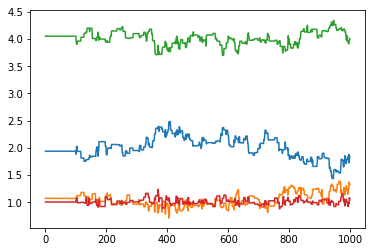

In [185]:
plt.plot(posterior.data.numpy().T);